In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime as dt
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
plt.style.use('./src/stylesheets/eb3.mplstyle')

from src.utilities import DIN, INDOC, get_labels, recolor_lines, export, truncate_colormap
from src.project_definitions import ori, airnodes, A, wohnungen2, dir_results
from src.physics import RH
from src.graphs import thermal_comfort_2, comfort_hx_diagramm

ex = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
def overview_graph(plot_data, ex=False, start=None, end=None):
    
    plot_data.columns = plot_data.columns.droplevel(level=[0])
    plot_data = plot_data.loc[start:end]

    fig, axs = plt.subplots(5,1,figsize = DIN['A4'], sharex=True)
    i=0
    fig.suptitle(f'Übersicht der Simulationsergebnisse: \n{bauweisen[bui]} | Wohnung {ori[app]} | {room}\n\n', fontweight='bold')
    
    #------ Temperatur ------
    dfp = plot_data.filter(like='TOP').copy()
    axs[i].plot(dfp, label=get_labels(dfp), alpha = 0.75)

    dfp = db[bui].filter(like='Tamb').copy()
    axs[i].plot(dfp, label=get_labels(dfp), alpha = 0.75)

    recolor_lines(axs[i], 'Reds_r' ,minint=0 ,maxint=0.8)

    axs[i].set_title('Temperaturen', fontweight = 'bold')
    axs[i].set_ylabel('[°C]')
    axs[i].legend(loc='center right',ncol=2,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1

    #------ Luftwechsel ------
    dfp = plot_data.filter(like='ACR_tot').copy()
    dfp_mean = dfp.rolling('D').mean() #dfp.groupby(dfp.index.floor('5D')).mean()
    avg = float(dfp.mean())
    axs[i].plot(dfp, label='Luftwechselrate', alpha = 0.75)
    axs[i].plot(dfp_mean, label='mittlerer täglicher Luftwechsel', ls='dashed')
    axs[i].axhline(y=avg, linestyle='solid', label = 'mittlerer jährlicher Luftwechsel')
    recolor_lines(axs[i], 'Accent_r')

    axs[i].set_title('Luftwechsel im Airnode', fontweight = 'bold')
    axs[i].set_ylabel('[1/h]')
    axs[i].legend(loc='center right',ncol=2,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1

    #------ Luftfeuchte ------
    dfp = plot_data.filter(like='Rh').copy()

    axs[i].plot(dfp, label='Raumluft', alpha = 0.75)

    dfp = amb[bui].apply(lambda x: RH(g=x['X_amb'], t=x['Tamb']),axis=1).copy()

    axs[i].plot(dfp, label='Außenluft', alpha = 0.75)

    recolor_lines(axs[i], 'Blues_r',minint=0.2,maxint=0.8)

    axs[i].set_title('Luftfeuchte', fontweight = 'bold')
    axs[i].set_ylabel('[Rh-%]')
    axs[i].set_ylim(0,100)
    axs[i].legend(loc='center right',ncol=2,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1

    #------ CO2 ------
    dfp = plot_data.filter(like='CO2').copy()

    axs[i].plot(dfp, label=get_labels(dfp), alpha = 0.75)

    recolor_lines(axs[i], 'Greens_r', minint=0,maxint=0.5)

    axs[i].set_title('CO2 Konzentration im Airnode', fontweight = 'bold')
    axs[i].set_ylabel('[ppm]')
    axs[i].legend(loc='center right',ncol=2,bbox_to_anchor=(1,1.1),frameon=False)
    for spine in axs[i].spines:
        axs[i].spines[spine].set_visible(False)
    i+=1

    #------ Energie ------
    dfp = plot_data.filter(like='Q_').copy()
    try:
        dfp['Q_dhw'] = dfp.Q_tot_ht-dfp.Q_heat
        dfp.drop('Q_tot_ht',axis=1)
    except:
        pass
    axs[i].plot(dfp, label=get_labels(dfp), alpha = 0.75)

    recolor_lines(axs[i], 'Dark2')

    axs[i].set_title('Energieströme in das (+) und aus (-) dem Airnode', fontweight = 'bold')
    axs[i].set_ylabel('[Wh/m²]')
    axs[i].legend(loc='center right',ncol=2,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1

    #----- Layout Timelines -----
    for ax in axs:
        ax.set_xlim(plot_data.index.min(),plot_data.index.max())
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(ticker.NullFormatter())
        
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b '%y"))

        for tick in ax.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)
            tick.tick2line.set_markersize(0)
            tick.label1.set_horizontalalignment('center')
    fig.tight_layout()
    if ex:
        export(fig,os.path.join(dir_export,bui,'overview_a4'),filename='{}_{}_übersicht'.format(bui,room),extlist=['pdf'])

In [54]:
pfad = r'\\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\5_simulation\varianten'

varianten = {var : os.path.join(pfad, var,'TRNSYS','Model') for var in os.listdir(pfad)}

var = input(list(varianten.keys()))
dir_export = os.path.join(os.path.dirname(os.path.dirname(varianten[var])), 'Auswertung')

bauweisen = {'HM':'Massivholz', 'MW':'Ziegel', 'LB':'Leichtbeton'}

idx = [(item.split('_')[1], item.split('_')[0]) for item in airnodes]
    
area = {}
for app in ['WE1','WE2','WE3']:
    try:
        if app not in area:
            area[app] = {}
        area[app]['array'] = A[app]
        area[app]['sum'] = A.groupby(level=0).sum()[app]
        area[app]['%'] = (area[app]['array']/area[app]['sum'])
    except:
        continue

wohnungairnode = {}
for item in airnodes:
    strings = item.split('_')
    we = strings[1]
    an = strings[0]
    if we not in wohnungairnode:
        wohnungairnode[we] = []
    wohnungairnode[we].append(an)

rooms = []
for item in airnodes:
    strings = item.split('_')
    strings.pop(1)
    rooms.append('-'.join(strings))

approoms = {'WE1': rooms[:6], 'WE2':rooms[9:12],'WE3':rooms[12:18]}

folder = [os.path.join(varianten[var], folder, 'Results') for folder in os.listdir(varianten[var])]

folder = [os.path.join(folder[i], os.listdir(folder[i])[0]) for i in range(len(folder))]

files = {}
for f in folder:
    text = f.split('\\')[-3].split('-')
    bui = text[0]
    side = text[1]
    if bui not in files:
        files[bui] = {}
    files[bui][side] = f

In [55]:
def read_prn(file, years=[2021, 2022]):
    print('reading file: ', file)
    _df = []
    for year in years:
        with open(file,"r") as addout_file:               #open TRNLizard-Output File
            addout_lines = [line.split() for line in addout_file.readlines()]     #read file, line-by-line
        addout_lines.pop(0)

        for j, line in enumerate(addout_lines):
            if len(line) == 0:
                data = addout_lines[:j]
                break

        header = data.pop(0)
        df = pd.DataFrame(
            data, 
            columns=header, 
            dtype=float)
        timestep = float(df.Period.diff().dropna().unique())
        df['Period'] = df.Period-timestep
        df['Datetime'] = df['Period'].apply(lambda x: dt.datetime(year,1,1,0,0) + dt.timedelta((x)/24))
        df.set_index('Datetime', inplace=True)
        _df.append(df)
    df = pd.concat(_df)
    return df

In [56]:
db = {} #dict.fromkeys([bui.split('-')[0] for bui in os.listdir(pfad)])
amb={}
for bui in files:
    bui_df = []
    for side in files[bui]:
        df = read_prn(files[bui][side],[2021, 2022])
        bui_df.append(df)

    df = pd.concat(bui_df, axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    amb[bui] = df.iloc[:,:5].copy()
    amb[bui] = amb[bui].resample('H').sum()
    db[bui] = df.resample('H').sum()

    idx=[]

    for item in db[bui].columns:
        split = item.rsplit('_',3)
        if len(split) >= 4:
            idx.append((split[-2],split[-3]+'-'+split[-1],split[-3],split[0]))
        else:
            idx.append(('','','',item))
    if bui not in db:
        db[bui] = {}
    db[bui].columns = pd.MultiIndex.from_tuples(idx)

reading file:  \\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\5_simulation\varianten\Variante_2\TRNSYS\Model\HM-NORD\Results\AddOutput_1h.prn
reading file:  \\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\5_simulation\varianten\Variante_2\TRNSYS\Model\HM-SUED\Results\AddOutput_1h.prn
reading file:  \\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\5_simulation\varianten\Variante_2\TRNSYS\Model\LB-NORD\Results\AddOutput_1h.prn
reading file:  \\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\5_simulation\varianten\Variante_2\TRNSYS\Model\LB-SUED\Results\AddOutput_1h.prn
reading file:  \\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\5_simulation\varianten\Variante_2\TRNSYS\Model\MW-NORD\Results\AddOutput_1h.prn
reading file:  \\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einf

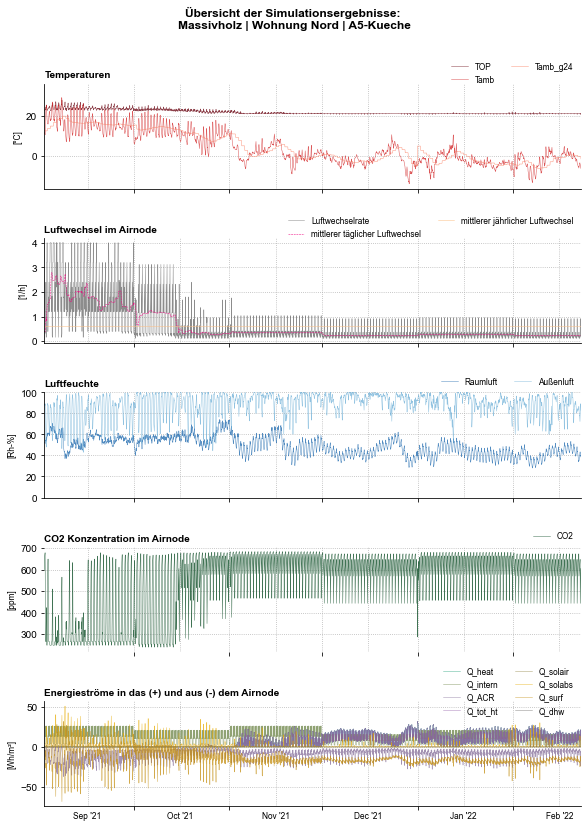

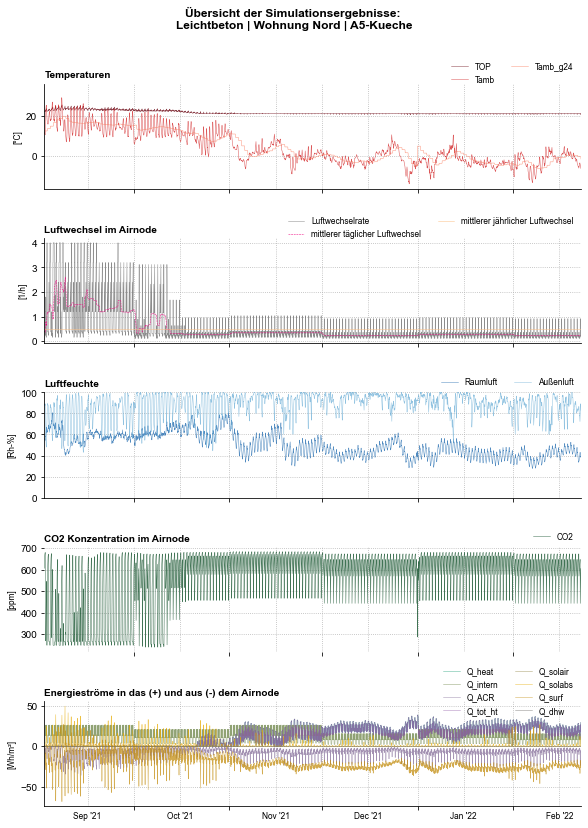

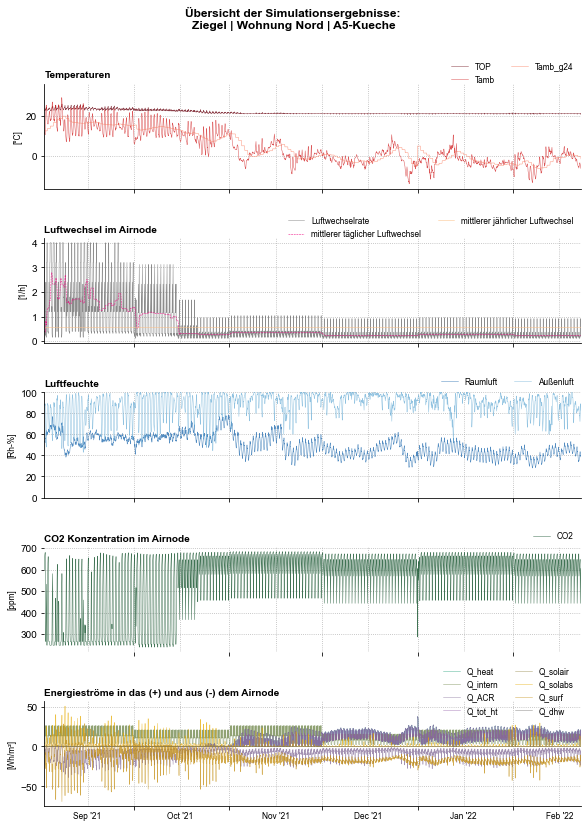

In [57]:
if not ex:
    for bui in db:
        app = 'WE1'
        room = approoms[app][4]

        plot_data = db[bui][app][room]

        overview_graph(plot_data,ex=ex, start='2021-09-02', end='2022-02-22')

In [58]:
if ex:
    for bui in db:
        for app in wohnungen2:
            for room in rooms:
                try:
                    plot_data = db[bui][app][room]
                except:
                    continue
                overview_graph(plot_data, ex=ex, start='2021-09-02', end='2022-02-22')

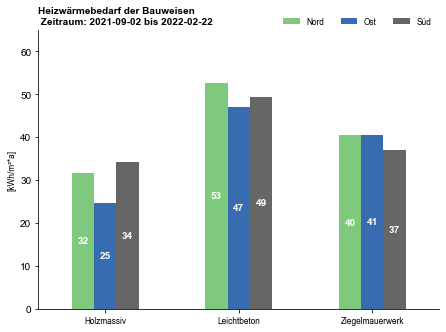

In [59]:
fig, axs = plt.subplots(figsize=INDOC)
start = '2021-09-02'
end = '2022-02-22'
qht = []
colnames = []
for i, bui in enumerate(db):
    qht.append((((db[bui].loc[start:end].groupby(level=[3],axis=1).get_group('Q_heat').sum().droplevel(level=[1,3])*A).groupby(level=0).sum()))/A.groupby(level=0).sum()/1000)
    colnames.append(bui)

df = pd.concat(qht,axis=1)
df.columns = colnames
df.dropna(inplace=True)
df.index = ['Nord', 'Ost','Süd']
df.T.plot.bar(ax = axs,cmap='Accent')

axs.set_title(f'Heizwärmebedarf der Bauweisen\n Zeitraum: {start} bis {end}', fontweight = 'bold')
axs.set_ylabel('[kWh/m²*a]')
axs.set_ylim(0,65)
axs.set_xticklabels(['Holzmassiv', 'Leichtbeton', 'Ziegelmauerwerk'], rotation=0)
xticks=[]
for bar in axs.patches:
    xticks.append(bar.get_x())

    axs.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f'{bar.get_height():.0f}',
        ha='center',
        va='center',
        color='w',
        weight='bold',
        )
axs.legend(frameon=False,ncol=3,loc='center right',bbox_to_anchor=(1,1.03))
axs.grid(False)
plt.subplots_adjust(top=0.5)
fig.tight_layout()
if ex:
    export(fig,dir_export,'Vergleich_Heizwärmebedarf',extlist=['pdf'])


In [60]:
plt.style.use('./src/stylesheets/eb3_präsi.mplstyle')

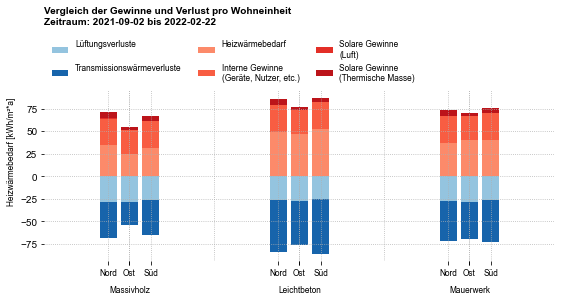

In [78]:
Q={}
for b, bui in enumerate(db):
    #print('---------{}---------'.format(bui))   
    if bui not in Q:
        Q[bui] = {}
    for a, app in enumerate(wohnungen2):
        try:
            if app not in Q[bui]:
                Q[bui][app] = {}
            A_we = np.array(A.filter(like=app))
            A_sum = np.array(A.filter(like=app)).sum()
            #print('------{}------'.format(app))
            for meter in ['Q_heat', 'Q_intern', 'Q_ACR','Q_surf','Q_solair','Q_solabs']:
                Q[bui][app][meter] = round((db[bui].loc[start:end][app].filter(like=meter).sum()*A_we).sum()/A_sum/1000,2)
                #print('{}: {} [kWh/m²]'.format(meter, Q[bui][app][meter]))
        except:
            continue

Q = pd.DataFrame.from_dict({(i,j): Q[i][j] 
                           for i in Q.keys() 
                           for j in Q[i].keys()},
                       orient='index').T

Q.columns = Q.columns.swaplevel(0,1)
Q.dropna(axis=1,inplace=True)
Q.sort_index(inplace=True, axis=1)

fig,axs = plt.subplots()

w = 0.1

cmap = plt.get_cmap('Reds')
red = truncate_colormap(cmap, 0.4, 0.8)

cmap = plt.get_cmap('Blues')
green = truncate_colormap(cmap, 0.4, 0.8)

we1 = Q.sort_index(axis=1)['WE1'].T
we1[we1<0].dropna(axis=1).plot.bar(stacked=True,width = w, position = -0.75,ax=axs,cmap=green)
we1[we1>0].dropna(axis=1).plot.bar(stacked=True,width = w, position = -0.75,ax=axs,cmap=red)

we2 = Q.sort_index(axis=1)['WE2'].T
we2[we2<0].dropna(axis=1).plot.bar(stacked=True,width = w, position = 0.5,ax=axs,cmap=green)
we2[we2>0].dropna(axis=1).plot.bar(stacked=True,width = w, position = 0.5,ax=axs,cmap=red)

we3 = Q.sort_index(axis=1)['WE3'].T
we3[we3<0].dropna(axis=1).plot.bar(stacked=True,width = w, position = 1.75,ax=axs,cmap=green)
we3[we3>0].dropna(axis=1).plot.bar(stacked=True,width = w, position = 1.75,ax=axs,cmap=red)

xticks=[]
for bar in axs.patches:
    xticks.append(bar.get_x())
    # axs.text(
    #     bar.get_x() + bar.get_width() / 2,
    #     bar.get_height()*0.5 + bar.get_y(),
    #     round(bar.get_height(),1),
    #     ha='center',
    #     color='w',
    #     size=6,
    #     weight='bold',
    #     )

xticks = [x+(w*0.5) for x in list(dict.fromkeys(xticks))]
xticks.sort()

ax2 = axs.twiny()
ax2.set_xticks(xticks)

axs.set_xlim(-0.5,2.5)
ax2.set_xlim(-0.5,2.5)

ax2.set_xticklabels(['Nord','Ost','Süd','Nord','Ost','Süd','Nord','Ost','Süd',])
ax2.xaxis.tick_bottom()

x_locator = ticker.FixedLocator([0,1,2])
x_formatter = ticker.FixedFormatter(['Massivholz','Leichtbeton','Mauerwerk'])


x_locator = ticker.FixedLocator([0.5, 1.5, 2.5])
ax2.xaxis.set_minor_locator(x_locator)

axs.set_xticks([0,1,2])
axs.set_xticklabels(['Massivholz','Leichtbeton','Mauerwerk'],rotation = 0)
axs.tick_params(axis = 'x', which='major', pad=20)
ax2.tick_params(axis = 'x', which='minor', length=0)

axs.legend(
    labels=['Lüftungsverluste\n', 'Transmissionswärmeverluste\n', 'Heizwärmebedarf\n', 'Interne Gewinne\n(Geräte, Nutzer, etc.)', 'Solare Gewinne\n(Luft)', 'Solare Gewinne\n(Thermische Masse)'],
    handles=axs.get_legend_handles_labels()[0][:6],
    frameon=False,
    ncol=3,bbox_to_anchor=(0,1),loc='lower left')


for spine in axs.spines:
    axs.spines[spine].set_visible(False)

for spine in ax2.spines:
    ax2.spines[spine].set_visible(False)

axs.grid(axis='y',linestyle='dotted')

axs.set_ylabel('Heizwärmebedarf [kWh/m²*a]   ', loc='top')

axs.set_title(f'Vergleich der Gewinne und Verlust pro Wohneinheit\nZeitraum: {start} bis {end}', fontweight = 'bold',y=1.35)

fig.tight_layout()
if ex:
    export(fig,dir_export,'Vergleich_Gewinne_u_Verluste',['pdf','png'] )

In [62]:
plt.style.use('./src/stylesheets/eb3.mplstyle')

In [63]:
Q={}
for b, bui in enumerate(db):
    if bui not in Q:
        Q[bui] = {}
    for a, app in enumerate(wohnungen2):
        try:
            if app not in Q[bui]:
                Q[bui][app] = {}
            A_we = np.array(A.filter(like=app))
            A_sum = np.array(A.filter(like=app)).sum()
            #print('------{}------'.format(app))
            for meter in ['Q_heat', 'Q_intern', 'Q_ACR','Q_surf','Q_solair','Q_solabs','Q_tot_ht']:
                Q[bui][app][meter] = round((db[bui].loc['2021'][app].filter(like=meter).sum()*A_we).sum()/A_sum/1000,2)
                #print('{}: {} [kWh/m²]'.format(meter, Q[bui][app][meter]))
        except:
            continue

Q = pd.DataFrame.from_dict({(i,j): Q[i][j] 
                           for i in Q.keys() 
                           for j in Q[i].keys()},
                       orient='index').T

Q.columns = Q.columns.swaplevel(0,1)
Q.dropna(axis=1,inplace=True)
Q.sort_index(inplace=True, axis=1)


exdir = os.path.join(dir_results,'Simulation')
if os.path.isdir(exdir)==False: os.makedirs(exdir)
Q.to_csv(os.path.join(exdir,f'Energie_{var}.csv'))

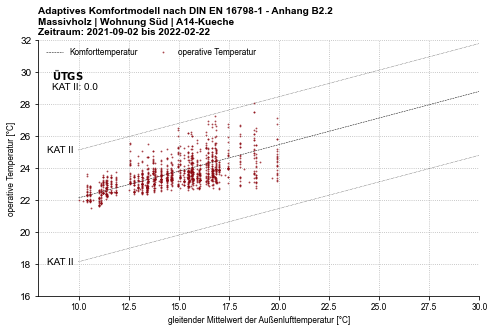

In [64]:
bui='HM'
app='WE3'
room=approoms[app][4]

fig,axs = plt.subplots()
thermal_comfort_2(amb[bui].Tamb_g24, db[bui].loc[start:end][app][room].droplevel(level=0,axis=1).TOP,axs,mode='op')
axs.set_title(f'Adaptives Komfortmodell nach DIN EN 16798-1 - Anhang B2.2\n{bauweisen[bui]} | Wohnung {ori[app]} | {room}\nZeitraum: {start} bis {end}',fontweight = 'bold')

if ex:
    for bui in db:
        for app in wohnungen2:
            for room in rooms:
                if room in db[bui][app].columns:
                    fig,axs = plt.subplots(figsize=INDOC)
                    try:
                        thermal_comfort_2(amb[bui].Tamb_g24,db[bui].loc[start:end][app][room].droplevel(level=0,axis=1).TOP,axs,mode='op')
                        axs.set_title(f'Adaptives Komfortmodell nach DIN EN 16798-1 - Anhang B2.2\n{bauweisen[bui]} | Wohnung {ori[app]} | {room}\nZeitraum: {start} bis {end}',fontweight = 'bold')
                        export(fig,os.path.join(dir_export,bui,'comfort'),f'{bui}_{app}_{room}_adaptive_comfort',['pdf'])
                        #print('{} | {} | {} erfolgreich exportiert!'.format(bauweisen[bui],app, room))
                    except:
                        continue

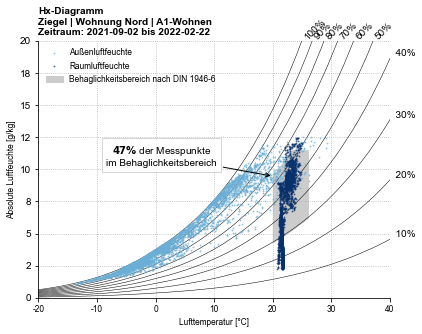

In [79]:
app='WE1'
room='A1-Wohnen'

fig,axs = plt.subplots(figsize=INDOC)
t1 = db[bui].loc[start:end][app][room].droplevel(level=0,axis=1).Tair
t2 = amb[bui].loc[start:end].Tamb
rh1 = db[bui].loc[start:end][app][room].droplevel(level=0,axis=1).Rh
rh2 = amb[bui].loc[start:end].apply(lambda x: RH(g=x['X_amb'], t=x['Tamb']),axis=1)
comfort_hx_diagramm(t1 = t1, rh1 = rh1, rh2=rh2, t2=t2, ax=axs)
axs.set_title(f'Hx-Diagramm\n{bauweisen[bui]} | Wohnung {ori[app]} | {room}\nZeitraum: {start} bis {end}',fontweight = 'bold')

if ex:
    for bui in db:
        for app in wohnungen2:
            for room in rooms:
                if room in db[bui][app].columns:
                    try:
                        fig,axs = plt.subplots(figsize=INDOC)
                        t1 = db[bui].loc[start:end][app][room].droplevel(level=0,axis=1).Tair
                        t2 = amb[bui].loc[start:end].Tamb
                        rh1 = db[bui].loc[start:end][app][room].droplevel(level=0,axis=1).Rh
                        rh2 = amb[bui].loc[start:end].apply(lambda x: RH(g=x['X_amb'], t=x['Tamb']),axis=1)
                        comfort_hx_diagramm(t1 = t1, rh1 = rh1, rh2=rh2, t2=t2, ax=axs)
                        axs.set_title(f'Hx-Diagramm\n{bauweisen[bui]} | Wohnung {ori[app]} | {room}\nZeitraum: {start} bis {end}',fontweight = 'bold')
                        export(fig,os.path.join(dir_export,bui,'hx'),f'{bui}_{app}_{room}_hx',['pdf'])
                    except:
                        continue

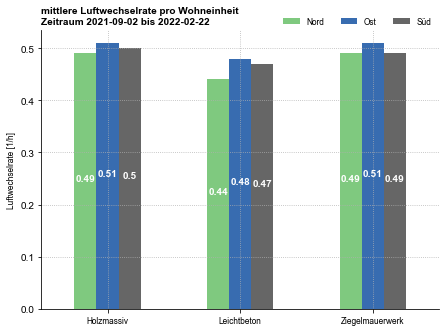

In [82]:
acr = {}

for bui in db:
    if bui not in acr:
        acr[bui]={}
        for app in wohnungen2:
            try:
                acr_app = round((db[bui].loc[start:end][app].filter(like='ACR_tot').mean().droplevel([0,2])*area[app]['%']).sum(),2)
                acr[bui][app] = acr_app
            except:
                continue

fig,axs = plt.subplots(figsize=INDOC)
df = pd.DataFrame.from_dict(acr).T
df.columns = ['Nord','Ost','Süd']
df.plot.bar(ax=axs,cmap='Accent')

axs.set_xticklabels(['Holzmassiv', 'Leichtbeton', 'Ziegelmauerwerk'], rotation=0)
axs.set_title(f'mittlere Luftwechselrate pro Wohneinheit\nZeitraum {start} bis {end}',fontweight = 'bold')
axs.set_ylabel('Luftwechselrate [1/h]')
xticks=[]
for bar in axs.patches:
    xticks.append(bar.get_x())

    axs.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        round(bar.get_height(),2),
        ha='center',
        color='w',
        weight='bold',
        )
axs.legend(frameon=False,ncol=3,loc='center right',bbox_to_anchor=(1,1.03))

fig.tight_layout()
if ex:
    export(fig,dir_export,'mittlere_Luftwechselraten',['pdf'])

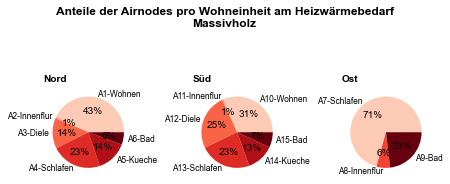

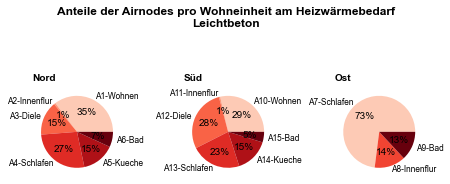

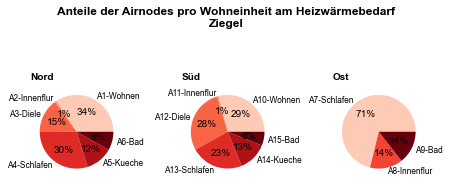

In [67]:
app = 'WE1'
room = 'A6-Bad'

for bui in db:
    fig, axs = plt.subplots(1,3, figsize=(6.3,3.15))
    for a, app in enumerate(wohnungen2):
        df = (db[bui][app].groupby(level=2,axis=1).get_group('Q_heat').sum().droplevel([0,2])*area[app]['%'])

        df = pd.DataFrame(df)

        df.index = approoms[app]

        df.columns = ['Q_heat']

        df.plot.pie(y='Q_heat',ax=axs[a], autopct='%1.0f%%', cmap=truncate_colormap('Reds',0.2))

        axs[a].set_title(f'{ori[app]}')
        axs[a].legend().remove()
        axs[a].set_ylabel('')

    fig.suptitle(f'Anteile der Airnodes pro Wohneinheit am Heizwärmebedarf\n{bauweisen[bui]}',fontweight = 'bold')
    fig.set_facecolor('white')
    #plt.subplots_adjust(top=0.5)
    fig.tight_layout()
    if ex:
        export(fig, os.path.join(dir_export,bui),f'{bui}_Vergleich_Heizwärmebedarf',['pdf'] )

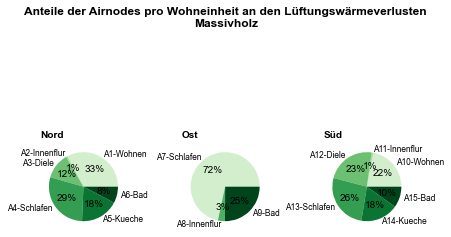

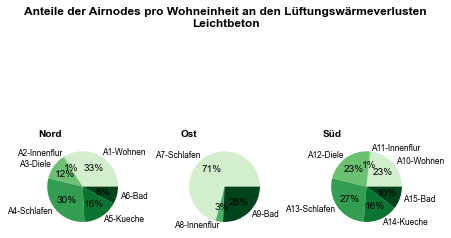

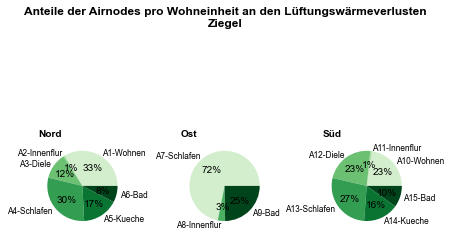

In [68]:
app = 'WE1'
room = 'A6-Bad'

for bui in db:
    fig, axs = plt.subplots(1,3, figsize=INDOC)
    for a, app in enumerate(ori):
        df = (db[bui][app].groupby(level=2,axis=1).get_group('Q_ACR').sum().droplevel([0,2])*area[app]['%'])

        df = pd.DataFrame(df)

        df.index = approoms[app]

        df.columns = ['Q_ACR']

        df.abs().plot.pie(y='Q_ACR',ax=axs[a], autopct='%1.0f%%', cmap=truncate_colormap('Greens',0.2))
        axs[a].set_title(f'{ori[app]}')
        axs[a].legend().remove()
        axs[a].set_ylabel('')
    
    fig.suptitle(f'Anteile der Airnodes pro Wohneinheit an den Lüftungswärmeverlusten\n{bauweisen[bui]}',fontweight = 'bold')
    fig.set_facecolor('white')
    fig.tight_layout()
    if ex:
        export(fig, os.path.join(dir_export,bui),f'{bui}_Vergleich_Lüftungswärmeverluste',['pdf'])

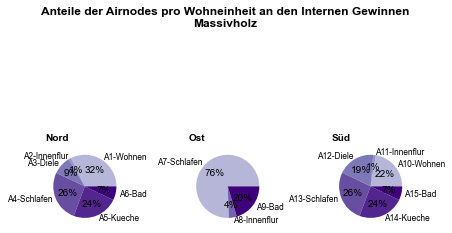

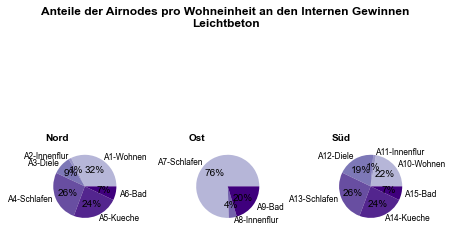

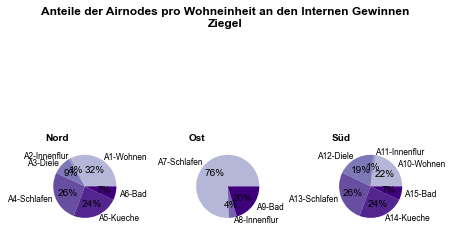

In [69]:
app = 'WE1'
room = 'A6-Bad'
gain = 'Q_intern'
loss = False

for bui in db:
    fig, axs = plt.subplots(1,3, figsize=INDOC)
    for a, app in enumerate(ori):
        df = (db[bui][app].groupby(level=2,axis=1).get_group(gain).sum().droplevel([0,2])*area[app]['%'])

        df = pd.DataFrame(df)

        df.index = approoms[app]

        df.columns = [gain]

        if loss:
            df = df.abs()

        df.plot.pie(y=gain,ax=axs[a], autopct='%1.0f%%', cmap=truncate_colormap('Purples',0.4))
        axs[a].set_title(f'{ori[app]}')
        axs[a].legend().remove()
        axs[a].set_ylabel('')

    fig.suptitle(f'Anteile der Airnodes pro Wohneinheit an den Internen Gewinnen\n{bauweisen[bui]}',fontweight = 'bold')
    fig.set_facecolor('white')
    fig.tight_layout()
    if ex:
        export(fig, os.path.join(dir_export,bui),f'{bui}_Vergleich_Interne_Gewinne',['pdf'])